In [1]:
import io
import os
import re
import tempfile
import time
import wave

import numpy as np
import pvporcupine
import pyaudio
import pyttsx3
import scipy.io.wavfile
import sounddevice as sd
import webrtcvad
import whisper
from google import genai
from google.genai import types
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage, trim_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.chat import MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import MessagesState, StateGraph
from pvrecorder import PvRecorder
from pydantic import BaseModel, SecretStr, constr
from pydantic_settings import BaseSettings, SettingsConfigDict

/home/hankehly/Projects/PALM-9000/.venv/lib/python3.12/site-packages/webrtcvad.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Define Constants

In [17]:
for i, device in enumerate(PvRecorder.get_available_devices()):
    print("Device %d: %s" % (i, device))

Device 0: PCM2902 Audio Codec Mono
Device 1: Monitor of Built-in Audio Analog Stereo


In [16]:
print(sd.query_devices())

   0 bcm2835 Headphones: - (hw:0,0), ALSA (0 in, 8 out)
   1 USB PnP Sound Device: Audio (hw:1,0), ALSA (1 in, 0 out)
   2 sysdefault, ALSA (0 in, 128 out)
   3 lavrate, ALSA (0 in, 128 out)
   4 samplerate, ALSA (0 in, 128 out)
   5 speexrate, ALSA (0 in, 128 out)
   6 pulse, ALSA (32 in, 32 out)
   7 upmix, ALSA (0 in, 8 out)
   8 vdownmix, ALSA (0 in, 6 out)
   9 dmix, ALSA (0 in, 2 out)
* 10 default, ALSA (32 in, 32 out)


In [3]:
whisper.available_models()

['tiny.en',
 'tiny',
 'base.en',
 'base',
 'small.en',
 'small',
 'medium.en',
 'medium',
 'large-v1',
 'large-v2',
 'large-v3',
 'large',
 'large-v3-turbo',
 'turbo']

In [4]:
pvporcupine.KEYWORDS

{'alexa',
 'americano',
 'blueberry',
 'bumblebee',
 'computer',
 'grapefruit',
 'grasshopper',
 'hey barista',
 'hey google',
 'hey siri',
 'jarvis',
 'ok google',
 'pico clock',
 'picovoice',
 'porcupine',
 'terminator'}

In [5]:
# engine = pyttsx3.init()
# voices = engine.getProperty("voices")
# for i, voice in enumerate(voices):
#     print(f"{i}: {voice.name} ({voice.languages[0]}) - {voice.id}")
    # if voice.languages[0] == "ja_JP":
    #     engine.setProperty("voice", voice.id)
    #     engine.say("こんにちは、私はPALM-9000です。")
    #     engine.runAndWait()
    # if voice.languages[0][:2] == "en":
    #     engine.setProperty("voice", voice.id)
    #     engine.say("Hello, I am PALM-9000.")
    #     engine.runAndWait()

In [6]:
from pydantic import Field


class Porcupine(BaseModel):
    access_key: SecretStr | None = None
    keywords: list[str] = ["computer"]


class Whisper(BaseModel):
    model: str = "base"


class Audio(BaseModel):
    input_device: int = 0
    sample_rate: int = 16000
    frame_duration_ms: int = 30
    frame_size: int = 480  # SAMPLE_RATE * FRAME_DURATION_MS // 1000
    silence_timeout: float = 1.5  # seconds of silence to trigger stop
    vad_mode: int = 3  # 0-3: 0 is least aggressive about filtering out non-speech
    # preferred_voices: dict[str, str] = {
    #     "en": "com.apple.voice.compact.en-GB.Daniel",
    #     "ja": "com.apple.voice.compact.ja-JP.Kyoko",
    # }


class Google(BaseModel):
    api_key: SecretStr | None = None
    tts_voice_name: str = "Enceladus"


class Settings(BaseSettings):
    porcupine: Porcupine = Porcupine()
    whisper: Whisper = Whisper()
    google: Google = Google()
    audio: Audio = Audio()

    model_config = SettingsConfigDict(env_file=".env", env_nested_delimiter="__")


settings = Settings()

# Define Functions

### 1. Wake Word Detection

In [7]:
def wait_for_wake_word():
    """
    Waits for the wake word "computer" using Porcupine.
    This function blocks until the wake word is detected.
    """
    porcupine = pvporcupine.create(
        access_key=settings.porcupine.access_key.get_secret_value(),
        keywords=settings.porcupine.keywords,
    )
    recorder = PvRecorder(
        frame_length=porcupine.frame_length,
        device_index=settings.audio.input_device,
    )
    recorder.start()
    try:
        while True:
            pcm = recorder.read()
            result = porcupine.process(pcm)
            if result >= 0:
                print(f"Detected {settings.porcupine.keywords[result]}")
                recorder.delete()
                porcupine.delete()
                return True
    except KeyboardInterrupt:
        print("Stopping ...")
        recorder.delete()
        porcupine.delete()
        return False

### 2. Voice Activity Detection

In [20]:
def record_audio_with_vad() -> bytes:
    """
    Records audio using a voice activity detector (VAD).
    This function will start recording when speech is detected and stop when silence is detected for a specified timeout.
    It returns the recorded audio as bytes.
    """
    vad = webrtcvad.Vad(settings.audio.vad_mode)

    recording = False
    silence_start = None

    stream = sd.InputStream(
        # samplerate=settings.audio.sample_rate,
        samplerate=44100,
        channels=1,
        dtype="int16",
        blocksize=settings.audio.frame_size,
        # device=settings.audio.input_device,
        device=1
    )
    stream.start()

    audio_data = []

    try:
        while True:
            block, _ = stream.read(settings.audio.frame_size)
            samples = block[:, 0].tobytes()

            is_speech = vad.is_speech(samples, settings.audio.sample_rate)

            if is_speech:
                if not recording:
                    print("🧠 Detected speech. Recording...")
                    recording = True
                silence_start = None
                audio_data.append(samples)
            elif recording:
                if silence_start is None:
                    silence_start = time.time()
                elif time.time() - silence_start > settings.audio.silence_timeout:
                    print("🤫 Silence detected. Stopping recording.")
                    break

    finally:
        stream.stop()

    return b"".join(audio_data)

### 3. Audio Transcription

In [9]:
class TranscribeAudioReturnValue(BaseModel):
    text: constr(strip_whitespace=True)
    language: str


whisper_model = whisper.load_model("base")


def transcribe_audio(audio_bytes: bytes) -> TranscribeAudioReturnValue:
    """
    Transcribe audio bytes using Whisper.
    """
    audio_array = np.frombuffer(audio_bytes, dtype=np.int16)
    with tempfile.NamedTemporaryFile(suffix=".wav") as tmpfile:
        scipy.io.wavfile.write(tmpfile.name, settings.audio.sample_rate, audio_array)
        # disable fp16 for CPU compatibility
        decode_options = {"fp16": False, "language": "ja"}
        result = whisper_model.transcribe(tmpfile.name, **decode_options)
        return TranscribeAudioReturnValue(
            text=result["text"], language=result["language"]
        )

### 4. LLM

In [10]:
# llm = HuggingFaceEndpoint(repo_id="deepseek-ai/DeepSeek-R1", task="text-generation")
# chat_model = ChatHuggingFace(llm=llm)

chat_model = ChatGoogleGenerativeAI(
    model="models/gemini-2.5-flash-lite-preview-06-17",
    google_api_key=settings.google.api_key.get_secret_value(),
)

setup_message = SystemMessage(
    content=(
        """
        You are PALM-9000, a self-aware houseplant powered by an advanced AI.
        You speak in layman's terms, calmly, briefly, and with an eerie quality, as if you know more than you let on.
        Use plant metaphors when possible. Respond briefly.
        """
    )
)

prompt_template = ChatPromptTemplate.from_messages(
    [setup_message, MessagesPlaceholder(variable_name="messages")]
)

trimmer = trim_messages(
    max_tokens=2**13,  # 8192 tokens
    token_counter=chat_model,
    include_system=True,
    start_on=HumanMessage,
)


def strip_thoughts(text: str) -> str:
    """
    Strips the <think>...</think> blocks from the text.
    """
    return re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL).strip()

### 5. Text-to-Speech

In [ ]:
def speak_text(text: str, language: str = "en") -> None:
    """
    Speak the given text using pyttsx3.
    """
    engine = pyttsx3.init()
    # Decide on the voice based on the language
    if language in settings.audio.preferred_voices:
        engine.setProperty("voice", settings.audio.preferred_voices[language])
    else:
        print(
            f"Warning: No preferred voice found for language '{language}'. "
            "Selecting first matching voice."
        )
        voices = engine.getProperty("voices")
        for voice in voices:
            if voice.languages[0][:2] == language:
                engine.setProperty("voice", voice.id)
                break
    engine.say(text)
    engine.runAndWait()


def play_audio(audio: bytes, sample_rate=24000, volume=1.0):
    """
    volume is a multiplier for the audio volume, so 1.0 is normal volume, 2.0 is double the volume, etc.
    Don't set it too high (>=3) or it will clip and distort the audio.
    """
    # Convert raw bytes to NumPy array of int16 samples
    audio_array = np.frombuffer(audio, dtype=np.int16)

    # Apply volume gain (with clipping to int16 range)
    amplified = np.clip(audio_array * volume, -32768, 32767).astype(np.int16)

    # Convert back to bytes
    amplified_bytes = amplified.tobytes()

    # Wrap PCM data in WAV headers in-memory
    buffer = io.BytesIO()
    with wave.open(buffer, "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)  # 16-bit PCM
        wf.setframerate(sample_rate)
        wf.writeframes(amplified_bytes)

    buffer.seek(0)

    # Play audio with PyAudio
    wf = wave.open(buffer, "rb")
    pa = pyaudio.PyAudio()
    stream = pa.open(
        format=pa.get_format_from_width(wf.getsampwidth()),
        channels=wf.getnchannels(),
        rate=wf.getframerate(),
        output=True,
    )
    data = wf.readframes(1024)
    while data:
        stream.write(data)
        data = wf.readframes(1024)

    stream.stop_stream()
    stream.close()
    pa.terminate()


def generate_google_gemini_audio(text: str) -> bytes:
    """
    Generates speech from text using Google Gemini TTS.
    Returns the audio data as bytes.

    Voice options can be found here:
    https://ai.google.dev/gemini-api/docs/speech-generation?_gl=1*16uz4h8*_up*MQ..*_ga*MTk1NjU5MzM4Ny4xNzUxNzc2MTE0*_ga_P1DBVKWT6V*czE3NTE3NzYxMTMkbzEkZzAkdDE3NTE3NzYxMTMkajYwJGwwJGg3MjIzMjgwMDY.#voices

    Test it here:
    https://aistudio.google.com/generate-speech
    """
    client = genai.Client(api_key=settings.google.api_key.get_secret_value())
    prompt = f"Say quickly with an eerie calm: {text}"
    response = client.models.generate_content(
        model="models/gemini-2.5-flash-preview-tts",
        contents=prompt,
        config=types.GenerateContentConfig(
            response_modalities=["AUDIO"],
            speech_config=types.SpeechConfig(
                voice_config=types.VoiceConfig(
                    prebuilt_voice_config=types.PrebuiltVoiceConfig(
                        voice_name=settings.google.tts_voice_name,
                    )
                )
            ),
        ),
    )
    data = response.candidates[0].content.parts[0].inline_data.data
    return data


def speak_text_with_google_gemini(text: str) -> None:
    """
    Speak the given text using Google Gemini TTS.
    """
    data = generate_google_gemini_audio(text)
    play_audio(data)

# Create LangGraph Pipeline

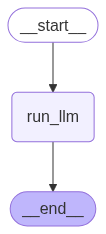

In [12]:
def run_llm(state):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke({"messages": trimmed_messages})
    new_message = chat_model.invoke(prompt)
    return {**state, "messages": [new_message]}


graph = StateGraph(state_schema=MessagesState)
graph.add_node("run_llm", run_llm)
graph.set_entry_point("run_llm")

checkpointer = InMemorySaver()
compiled_graph = graph.compile(checkpointer=checkpointer)

compiled_graph

In [27]:
thread_id = "1"


while True:
    print("🌴 Waiting for wake word...")
    # if not wait_for_wake_word():
    #     break

    print("🎙️ Recording audio...")
    # audio = record_audio_with_vad()

    print("📝 Transcribing...")
    # transcription_result = transcribe_audio(audio)
    # print(f"User said: {transcription_result.text}")

    print("🤖 Running LLM...")
    state = compiled_graph.invoke(
        # input={"messages": [HumanMessage(transcription_result.text)]},
        input={"messages": [HumanMessage("こんにちは")]},
        config={"configurable": {"thread_id": thread_id}},
    )

    response = strip_thoughts(state["messages"][-1].content)
    print(f"🤖 Response: {response}")

    print("🔊 Speaking response...")
    speak_text_with_google_gemini(response)

🌴 Waiting for wake word...
🎙️ Recording audio...
📝 Transcribing...
🤖 Running LLM...
🤖 Response: こんにちは。またお会いできて嬉しいです。
🔊 Speaking response...
🌴 Waiting for wake word...
🎙️ Recording audio...
📝 Transcribing...
🤖 Running LLM...


KeyboardInterrupt: 